In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
#mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(11)
import h5py
from scipy.optimize import minimize

In [2]:
# Load AR results
precomputed_data = h5py.File("/mnt/home/sroy1/ar_lnm1_q_summary.hdf","r")
m1s = precomputed_data['posterior/m1s'][()]
dR_dlnm1s = precomputed_data['posterior/dR_dlnm1s'][()]

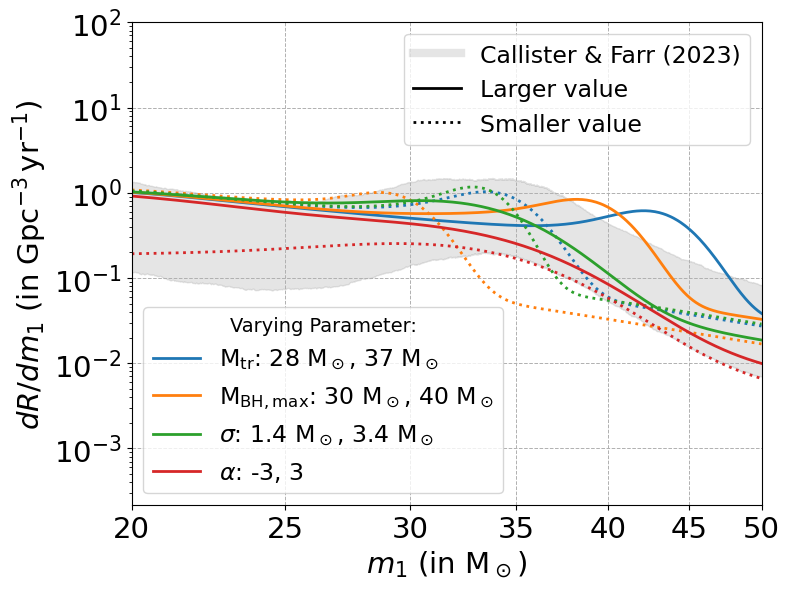

In [7]:
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.lines import Line2D

# Load your JSON file
with open("mass_spec_all_variations.json", "r") as f:
    data = json.load(f)

masses = np.array(data["masses"])
vary_mpisn = data["vary_mpisn"]
vary_mbhmax = data["vary_mbhmax"]
vary_sigma = data["vary_sigma"]
vary_b = data["vary_b"]

# Assume you already have these:
# m1s: mass grid for your AR samples
# dR_dlnm1s: AR posterior samples

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_rasterization_zorder(2)

# Plot the 90% credible interval band
lower = np.percentile(dR_dlnm1s / m1s[:, None], 5, axis=1)
upper = np.percentile(dR_dlnm1s / m1s[:, None], 95, axis=1)
ax.fill_between(m1s, lower, upper, color='gray', alpha=0.2, label='Callister & Farr (2023)')

# More prominent colors for variations
colors = {
    "mpisn": "#1f77b4",   # strong blue
    "mbhmax": "#ff7f0e",  # bright orange
    "sigma": "#2ca02c",   # vivid green
    "b": "#d62728"        # bold red
}

# Pretty legend labels
legend_labels = {
    "mpisn": r"$\mathrm{M}_\mathrm{tr}$",
    "mbhmax": r"$\mathrm{M}_{\mathrm{BH,max}}$",
    "sigma": r"$\sigma$",
    "b": r"$\alpha$"
}

# Determine extremes
mpisn_vals = sorted(set(entry["mpisn"] for entry in vary_mpisn))
mbhmax_vals = sorted(set(entry["mbhmax"] for entry in vary_mbhmax))
sigma_vals = sorted(set(entry["sigma"] for entry in vary_sigma))
b_vals = sorted(set(entry["b"] for entry in vary_b))

extremes = {
    "mpisn": [mpisn_vals[0], mpisn_vals[-1]],
    "mbhmax": [mbhmax_vals[0], mbhmax_vals[-1]],
    "sigma": [sigma_vals[0], sigma_vals[-1]],
    "b": [b_vals[0], b_vals[-1]],
}

# Store for legend handles
style_legend_handles = []
color_legend_handles = []

# Plot each variation with color and linestyle
for key, val_list in extremes.items():
    color = colors[key]
    for i, val in enumerate(val_list):
        linestyle = '-' if i == 1 else ':'  # solid for max, dotted for min

        # Fetch the corresponding entry
        if key == "mpisn":
            entry = next(e for e in vary_mpisn if e["mpisn"] == val)
        elif key == "mbhmax":
            entry = next(e for e in vary_mbhmax if e["mbhmax"] == val)
        elif key == "sigma":
            entry = next(e for e in vary_sigma if e["sigma"] == val)
        elif key == "b":
            entry = next(e for e in vary_b if e["b"] == val)

        dndm = np.array(entry["dndm"])
        if key == "b" and val == -3:
            dndm /= 15. / 0.2

        ax.plot(masses, dndm, color=color, lw=2, linestyle=linestyle)

    # Format values with proper units and scaling
    if key in ["mpisn", "mbhmax"]:
        v0 = f"{val_list[0]:.0f} $\\mathrm{{M}}_\\odot$"
        v1 = f"{val_list[1]:.0f} $\\mathrm{{M}}_\\odot$"
    elif key == "sigma":
        v0 = f"{val_list[0]*34:.1f} $\\mathrm{{M}}_\\odot$"
        v1 = f"{val_list[1]*34:.1f} $\\mathrm{{M}}_\\odot$"
    else:  # "b"
        v0 = f"{int(val_list[0])}"
        v1 = f"{int(val_list[1])}"

    label = f"{legend_labels[key]}: {v0}, {v1}"
    color_legend_handles.append(Line2D([0], [0], color=color, lw=2, label=label))

# Create linestyle legend (max/min)
style_legend_handles = [
    Line2D([0], [0], color='gray', lw=6, alpha=0.2, label='Callister & Farr (2023)'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Larger value'),
    Line2D([0], [0], color='black', lw=2, linestyle=':', label='Smaller value'),
]

# Add both legends
first_legend = ax.legend(handles=style_legend_handles, loc='upper right', fontsize=17, frameon=True)
second_legend = ax.legend(handles=color_legend_handles, title='Varying Parameter:', title_fontsize=14,
                          loc='lower left', fontsize=17, frameon=True)
ax.add_artist(first_legend)

# Axes formatting
fontsize = 21
ax.tick_params(labelsize=fontsize)
ax.set_xlim(20, 50)
ax.set_xscale('log')
ax.set_yscale('log')

# Custom x-ticks and grids
xticks = [20, 25, 30, 35, 40, 45, 50]
ax.set_xticks(xticks)
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.grid(True, axis='x', which='major', linestyle='--', linewidth=0.7)
ax.grid(True, axis='y', which='major', linestyle='--', linewidth=0.7)

# Axis labels
ax.set_xlabel('$m_1$ (in $\\mathrm{M}_\\odot$)', fontsize=fontsize)
ax.set_ylabel('$dR/dm_1$ (in $\\mathrm{Gpc}^{-3}\\,\\mathrm{yr}^{-1}$)', fontsize=fontsize)

plt.tight_layout()
plt.savefig('/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/match_ar1.pdf', bbox_inches='tight', dpi=200)
